In [ ]:
!unzip images.zip

Archive:  images.zip
   creating: images/
  inflating: images/team19_139.jpg   
  inflating: images/team19_1759150167457.jpg  
  inflating: images/team19_1759150171670.jpg  
  inflating: images/team19_1759150533744.jpg  
  inflating: images/team19_1759150566575.jpg  
  inflating: images/team19_1759151063226.jpg  
  inflating: images/team19_1759151065948.jpg  
  inflating: images/team19_1759151071735.jpg  
  inflating: images/team19_1759151075529.jpg  
  inflating: images/team19_1759151172870.jpg  
  inflating: images/team19_1759152072987.jpg  
  inflating: images/team19_20191005181729_2.jpg  
  inflating: images/team19_71p++9K+x3L._UF350,350_QL80_.jpg  
  inflating: images/team19_BagBalmMoisturizingSoap_3.9oz_4.jpg  
  inflating: images/team19_BBS_694c45df-7b39-486e-8502-d24f0f0fb456.jpg  
  inflating: images/team19_il_340x270.4258371409_f2hm.jpg  
  inflating: images/team19_il_340x270.6392176763_6uy0.jpg  
  inflating: images/team19_IMG-20250929-WA0021.jpg  
  inflating: images/team19

In [ ]:
from transformers import AutoFeatureExtractor, ViTForImageClassification
from PIL import Image

# Load pretrained model + feature extractor
feature_extractor = AutoFeatureExtractor.from_pretrained("facebook/deit-small-patch16-224")
model = ViTForImageClassification.from_pretrained("facebook/deit-small-patch16-224")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

/usr/local/lib/python3.12/dist-packages/transformers/models/vit/feature_extraction_vit.py:30: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


pytorch_model.bin:   0%|          | 0.00/88.3M [00:00<?, ?B/s]

finetune

In [ ]:
!pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 5.2 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from transformers import (
    Trainer,
    TrainingArguments,
    ViTModel,
    AutoFeatureExtractor  # Using AutoFeatureExtractor like in your example
)
from PIL import Image
from sklearn.metrics import accuracy_score
import numpy as np
import evaluate
from collections import defaultdict
import os

# Suppress harmless warnings from pandas
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [ ]:
# --- 1. CONFIGURATION ---

# !!! UPDATE THESE PATHS !!!
SINGLE_CSV_PATH = "/content/newlabels.csv" # The path to your CSV file in Colab
IMAGE_BASE_DIR = "/content/" # The base path for the 'images/...' column

# --- This is our explicit list of tasks ---
ATTRIBUTE_TASKS = ['color', 'material', 'condition', 'size']
# -------------------------------------------

# Model Configuration
# We can use the 'patch16' or 'distilled' version. 'distilled' is often a bit better.
MODEL_CHECKPOINT = "facebook/deit-small-patch16-224"
MODEL_NAME = "deit-small-finetuned"

# Training Configuration
LEARNING_RATE = 2e-5 # <--- CRITICAL: Low LR for fine-tuning
BATCH_SIZE = 16 # Adjust based on your Colab GPU (T4 should handle 16)
NUM_EPOCHS = 10 # Start with 10, can increase later

In [ ]:
def parse_attributes(attr_str):
    """
    Parses a string like 'color:white;material:plastic'
    into a dictionary {'color': 'white', 'material': 'plastic'}
    """
    if pd.isna(attr_str):
        return {}
    attributes = {}
    try:
        for item in attr_str.split(';'):
            if ':' in item:
                key, value = item.split(':', 1)
                attributes[key.strip()] = value.strip()
    except Exception as e:
        print(f"Error parsing attribute string: {attr_str} | Error: {e}")
    return attributes

def preprocess_dataframe(csv_path, attribute_task_list):
    """
    Loads the single CSV, parses *only* the specified attributes,
    and returns train/val dataframes and task info.
    """
    print(f"Loading data from {csv_path}...")
    df = pd.read_csv(csv_path)

    print("Parsing 'attributes' column...")
    attr_dicts = df['attributes'].apply(parse_attributes)
    attr_df = pd.DataFrame(attr_dicts.tolist())

    print(f"Filtering for specified attributes: {attribute_task_list}")
    found_attributes = [col for col in attribute_task_list if col in attr_df.columns]
    missing_attributes = [col for col in attribute_task_list if col not in attr_df.columns]

    if missing_attributes:
        print(f"Warning: Could not find columns for attributes: {missing_attributes}")

    attr_df = attr_df[found_attributes]

    df = pd.concat([df, attr_df], axis=1)
    df[found_attributes] = df[found_attributes].fillna('N/A')

    task_columns = ['class_label'] + found_attributes

    df_train = df[df['split'] == 'train'].reset_index(drop=True)
    df_val = df[df['split'] == 'val'].reset_index(drop=True)

    print(f"Created {len(df_train)} training samples and {len(df_val)} validation samples.")
    return df_train, df_val, task_columns

In [ ]:
def create_label_maps(df_train, df_val, task_cols):
    """Creates label-to-id and id-to-label maps for all tasks."""
    label2id = defaultdict(dict)
    id2label = defaultdict(dict)

    print("Creating label maps...")
    for col in task_cols:
        unique_labels = pd.concat([df_train[col], df_val[col]]).unique()
        unique_labels.sort()

        label2id[col] = {label: idx for idx, label in enumerate(unique_labels)}
        id2label[col] = {idx: label for idx, label in enumerate(unique_labels)}
        print(f"  Task '{col}': {len(unique_labels)} classes (e.g., {unique_labels[0]})")

    return label2id, id2label

In [ ]:
class MultiTaskImageDataset(Dataset):
    def __init__(self, df, feature_extractor, label2id_maps, task_cols, image_base_dir):
        self.df = df
        self.feature_extractor = feature_extractor
        self.label2id_maps = label2id_maps
        self.task_cols = task_cols
        self.image_base_dir = image_base_dir

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        image_path = os.path.join(self.image_base_dir, row['image_path'])

        try:
            image = Image.open(image_path).convert("RGB")
            pixel_values = self.feature_extractor(images=image, return_tensors="pt")['pixel_values'].squeeze()
        except Exception as e:
            print(f"Error loading image {image_path}: {e}")
            # On error, load the first image as a placeholder
            row0 = self.df.iloc[0]
            image0_path = os.path.join(self.image_base_dir, row0['image_path'])
            image = Image.open(image0_path).convert("RGB")
            pixel_values = self.feature_extractor(images=image, return_tensors="pt")['pixel_values'].squeeze()

        labels = []
        for col in self.task_cols:
            label_str = row[col]
            label_id = self.label2id_maps[col][label_str]
            labels.append(label_id)

        return {
            "pixel_values": pixel_values,
            "labels": torch.tensor(labels, dtype=torch.long)
        }

In [ ]:
# --- Cell 7 (Corrected) ---
from transformers import AutoModel # <-- Import AutoModel

class MultiTaskDeiT(nn.Module):
    def __init__(self, model_name, num_labels_per_task):
        super().__init__()
        self.num_tasks = len(num_labels_per_task)

        # 1. Load the backbone using AutoModel (UN-FROZEN by default)
        # This will correctly load a DeiTModel class
        self.vit = AutoModel.from_pretrained(model_name)

        # 2. Create a separate classification head for each task
        self.heads = nn.ModuleList()
        for num_labels in num_labels_per_task:
            head = nn.Sequential(
                nn.Dropout(0.1),
                nn.Linear(self.vit.config.hidden_size, num_labels)
            )
            self.heads.append(head)

    def forward(self, pixel_values, labels=None):
        outputs = self.vit(pixel_values=pixel_values)
        cls_output = outputs.last_hidden_state[:, 0, :]

        logits_list = [head(cls_output) for head in self.heads]

        loss = None
        if labels is not None:
            loss = 0
            loss_fct = nn.CrossEntropyLoss()
            for i in range(self.num_tasks):
                logits = logits_list[i]
                task_labels = labels[:, i]
                loss += loss_fct(logits.view(-1, self.heads[i][1].out_features), task_labels.view(-1))

            loss = loss / self.num_tasks # Average loss

        return {
            "loss": loss,
            "logits": tuple(logits_list)
        }

In [ ]:
# We need global vars for compute_metrics to see the task columns
g_task_columns = []
# Load the accuracy metric
g_accuracy_metric = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    logits_tuple, labels = eval_pred
    metrics = {}

    for i, task_name in enumerate(g_task_columns):
        task_logits = logits_tuple[i]
        task_labels = labels[:, i]

        preds = np.argmax(task_logits, axis=1)

        # Use the evaluate library to compute accuracy
        acc = g_accuracy_metric.compute(predictions=preds, references=task_labels)
        metrics[f"{task_name}_accuracy"] = acc["accuracy"] # extract the value

    metrics["average_accuracy"] = np.mean(list(metrics.values()))
    return metrics

# The Trainer's default collator is fine, but this is good practice
def collate_fn(batch):
    return {
        'pixel_values': torch.stack([x['pixel_values'] for x in batch]),
        'labels': torch.stack([x['labels'] for x in batch])
    }

In [ ]:
# 1. Pre-process the single CSV
df_train, df_val, task_columns = preprocess_dataframe(SINGLE_CSV_PATH, ATTRIBUTE_TASKS)
g_task_columns = task_columns # Set global var for compute_metrics

# 2. Create label maps
label2id, id2label = create_label_maps(df_train, df_val, task_columns)

# Get the number of labels for each task
num_labels_per_task = [len(label2id[col]) for col in task_columns]
print(f"\nFinal tasks and label counts: {list(zip(task_columns, num_labels_per_task))}")

# 3. Initialize feature extractor
feature_extractor = AutoFeatureExtractor.from_pretrained(MODEL_CHECKPOINT)

# 4. Create datasets
train_dataset = MultiTaskImageDataset(df_train, feature_extractor, label2id, task_columns, IMAGE_BASE_DIR)
val_dataset = MultiTaskImageDataset(df_val, feature_extractor, label2id, task_columns, IMAGE_BASE_DIR)
print(f"\nLoaded {len(train_dataset)} training examples and {len(val_dataset)} validation examples.")

Loading data from /content/newlabels.csv...
Parsing 'attributes' column...
Filtering for specified attributes: ['color', 'material', 'condition', 'size']
Created 449 training samples and 149 validation samples.
Creating label maps...
  Task 'class_label': 10 classes (e.g., electronics_accessories_keyboard)
  Task 'color': 29 classes (e.g., N/A)
  Task 'material': 7 classes (e.g., N/A)
  Task 'condition': 4 classes (e.g., N/A)
  Task 'size': 4 classes (e.g., N/A)

Final tasks and label counts: [('class_label', 10), ('color', 29), ('material', 7), ('condition', 4), ('size', 4)]

Loaded 449 training examples and 149 validation examples.


/usr/local/lib/python3.12/dist-packages/transformers/models/vit/feature_extraction_vit.py:30: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


In [ ]:
# --- Cell 10 (Corrected) ---

# 1. Initialize model
model = MultiTaskDeiT(MODEL_CHECKPOINT, num_labels_per_task)

# 2. Set up Training Arguments for FINE-TUNING
training_args = TrainingArguments(
    output_dir=MODEL_NAME,
    num_train_epochs=NUM_EPOCHS,
    learning_rate=LEARNING_RATE, # <-- LOW LR
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    logging_steps=20,
    eval_strategy="epoch",  # <-- RENAMED
    save_strategy="epoch",  # <-- RENAMED
    load_best_model_at_end=True,
    metric_for_best_model="average_accuracy",
    greater_is_better=True,
    remove_unused_columns=False, # We need 'labels', so set this to False
    push_to_hub=False,
    report_to="none",
)

# 3. Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    data_collator=collate_fn,
)

Some weights of ViTModel were not initialized from the model checkpoint at facebook/deit-small-patch16-224 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
print("Starting fine-tuning...")
print(f"Backbone: {MODEL_CHECKPOINT} (UNFROZEN)")
print(f"Tasks: {g_task_columns}")
print(f"LR: {LEARNING_RATE}, Epochs: {NUM_EPOCHS}, Batch Size: {BATCH_SIZE}")

trainer.train()

print("Fine-tuning complete.")

Starting fine-tuning...
Backbone: facebook/deit-small-patch16-224 (UNFROZEN)
Tasks: ['class_label', 'color', 'material', 'condition', 'size']
LR: 2e-05, Epochs: 10, Batch Size: 16


Epoch,Training Loss,Validation Loss,Class Label Accuracy,Color Accuracy,Material Accuracy,Condition Accuracy,Size Accuracy,Average Accuracy
1,1.821000,1.515701,0.302013,0.201342,0.536913,0.630872,0.859060,0.506040
2,1.422600,1.374190,0.496644,0.214765,0.664430,0.677852,0.845638,0.579866
3,1.017100,1.286580,0.597315,0.241611,0.738255,0.664430,0.791946,0.606711
4,0.907900,1.231143,0.691275,0.268456,0.758389,0.684564,0.765101,0.633557
5,0.647100,1.220474,0.704698,0.248322,0.778523,0.671141,0.758389,0.632215
6,0.540600,1.199576,0.697987,0.248322,0.791946,0.684564,0.758389,0.636242
7,0.468000,1.198567,0.731544,0.261745,0.805369,0.677852,0.758389,0.646980
8,0.418800,1.192021,0.738255,0.241611,0.812081,0.691275,0.758389,0.648322
9,0.381100,1.192405,0.738255,0.248322,0.812081,0.691275,0.758389,0.649664
10,0.349400,1.191729,0.738255,0.241611,0.812081,0.691275,0.758389,0.648322


Fine-tuning complete.


In [ ]:
# Save the final best model
trainer.save_model(f"{MODEL_NAME}/final_model_1")
print(f"Best model saved to {MODEL_NAME}/final_model_1")

Best model saved to deit-small-finetuned/final_model_1


In [ ]:
import pandas as pd
import warnings
from collections import defaultdict

# Suppress pandas warnings
warnings.filterwarnings("ignore", category=UserWarning)

# --- Configuration ---
# !!! UPDATE THIS PATH !!!
SINGLE_CSV_PATH = "/content/newlabels.csv" # Update this path to your uploaded file
ATTRIBUTE_TASKS = ['color', 'material', 'condition', 'size']
# ---------------------

def parse_attributes(attr_str):
    """
    Parses a string like 'color:white;material:plastic'
    into a dictionary {'color': 'white', 'material': 'plastic'}
    and cleans the keys/values.
    """
    if pd.isna(attr_str):
        return {}
    attributes = {}
    try:
        for item in str(attr_str).split(';'):
            if ':' in item:
                key, value = item.split(':', 1)
                key_clean = key.strip().lower()
                value_clean = value.strip().lower()
                attributes[key_clean] = value_clean
    except Exception as e:
        print(f"Error parsing attribute string: {attr_str} | Error: {e}")
    return attributes

try:
    print(f"Loading data from {SINGLE_CSV_PATH}...")
    df = pd.read_csv(SINGLE_CSV_PATH)

    print("Parsing 'attributes' column...")
    attribute_task_list = [task.lower() for task in ATTRIBUTE_TASKS]

    attr_dicts = df['attributes'].apply(parse_attributes)
    attr_df = pd.DataFrame(attr_dicts.tolist())

    print(f"Filtering for specified attributes: {attribute_task_list}")
    found_attributes = [col for col in attribute_task_list if col in attr_df.columns]

    attr_df = attr_df[found_attributes]

    df = pd.concat([df, attr_df], axis=1)

    # Clean the class_label column
    df['class_label'] = df['class_label'].str.lower().str.strip()

    # Fill any missing attributes with 'n/a'
    df[found_attributes] = df[found_attributes].fillna('n/a')

    # Split dataframe based on the 'split' column
    df_train = df[df['split'] == 'train'].reset_index(drop=True)
    df_val = df[df['split'] == 'val'].reset_index(drop=True)

    print(f"Found {len(df_train)} training samples and {len(df_val)} validation samples.")

    # --- Analysis ---
    print("\n" + "="*40)
    print("  Data Distribution Analysis (Training Set)")
    print("="*40)

    print("\n--- 1. Class Label Distribution ---")
    print(df_train['class_label'].value_counts())

    if 'color' in df_train.columns:
        print("\n" + "="*30 + "\n")
        print("--- 2. Color Label Distribution ---")
        print(df_train['color'].value_counts())

    if 'material' in df_train.columns:
        print("\n" + "="*30 + "\n")
        print("--- 3. Material Label Distribution ---")
        print(df_train['material'].value_counts())

    if 'condition' in df_train.columns:
        print("\n" + "="*30 + "\n")
        print("--- 4. Condition Label Distribution ---")
        print(df_train['condition'].value_counts())

    if 'size' in df_train.columns:
        print("\n" + "="*30 + "\n")
        print("--- 5. Size Label Distribution ---")
        print(df_train['size'].value_counts())

except FileNotFoundError:
    print(f"\n\n--- !!! ERROR !!! ---")
    print(f"Error: File not found at {SINGLE_CSV_PATH}")
    print("Please update the SINGLE_CSV_PATH variable in the code cell to point to your CSV file.")
except Exception as e:
    print(f"An error occurred: {e}")
    print("Please check your CSV file format and path.")

Loading data from /content/newlabels.csv...
Parsing 'attributes' column...
Filtering for specified attributes: ['color', 'material', 'condition', 'size']
Found 449 training samples and 149 validation samples.

  Data Distribution Analysis (Training Set)

--- 1. Class Label Distribution ---
class_label
personal_care_shampoo               45
personal_care_toothbrush            45
personal_care_soap                  45
travel_backpack                     45
electronics_accessories_keyboard    45
tableware_water_bottle              45
stationery_notebook                 45
electronics_accessories_mouse       45
stationery_pen                      45
footwear_sneakers                   44
Name: count, dtype: int64


--- 2. Color Label Distribution ---
color
black              110
white               55
grey                50
blue                49
green               20
red                 19
pink                16
silver              15
pink and white      10
orange              10
brown  

retrieval system - search index based

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
from pathlib import Path
from tqdm.auto import tqdm
import spacy
from safetensors.torch import load_file

from transformers import AutoFeatureExtractor, AutoModel

# --- 1. CONFIGURATION ---
class Config:
    CSV_PATH = "newlabels.csv"
    ATTRIBUTE_COLS = ['class_label', 'color', 'material', 'condition', 'size']
    MODEL_NAME = "facebook/deit-small-patch16-224" # Must match the model you trained
    DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
    RANDOM_SEED = 42

np.random.seed(Config.RANDOM_SEED)
torch.manual_seed(Config.RANDOM_SEED)

print(f"Using device: {Config.DEVICE}")
print(f"Using base model: {Config.MODEL_NAME}")

# --- 2. MODEL CLASS DEFINITION (MODIFIED) ---
# This class is now designed to match the keys in your .safetensors file
# e.g., "vit.embeddings..." and "heads.0.1.weight"
class MultiAttributeModel(nn.Module):
    def __init__(self, model_name, label_to_id_maps):
        super().__init__()
        self.label_maps = label_to_id_maps
        self.attributes = list(label_to_id_maps.keys())

        # 1. Backbone key is 'vit' (to match your file)
        self.vit = AutoModel.from_pretrained(model_name)

        self.hidden_dim = self.vit.config.hidden_size

        # 2. Heads are a ModuleList (to match 'heads.0', 'heads.1', etc.)
        #    and each head is a Sequential (to match 'heads.0.1.weight')
        self.heads = nn.ModuleList()
        for attr in self.attributes:
            num_classes = len(self.label_maps.get(attr, {}))
            if num_classes == 0:
                print(f"Warning: No classes found for attribute '{attr}'. Head will be a placeholder.")
                # Add a dummy module to keep indices aligned
                self.heads.append(nn.Identity())
            else:
                # This nn.Sequential block creates keys like 'heads.0.1.weight'
                # (where '0' is the index in the ModuleList and '1' is the index in Sequential)
                self.heads.append(
                    nn.Sequential(
                        nn.Identity(), # Placeholder for index 0
                        nn.Linear(self.hidden_dim, num_classes) # Your weights at index 1
                    )
                )

    def forward(self, pixel_values, labels=None):
        # 1. Use self.vit
        backbone_outputs = self.vit(pixel_values)
        pooled_output = backbone_outputs.last_hidden_state[:, 0]

        # 2. Iterate and use the ModuleList
        logits_dict = {}
        for i, attr in enumerate(self.attributes):
            # Check if the head is a real layer (not the placeholder)
            if isinstance(self.heads[i], nn.Sequential):
                logits_dict[attr] = self.heads[i](pooled_output)

        outputs = {"logits": logits_dict}
        return outputs

# --- 3. DATASET CLASS DEFINITION ---
# This is needed to load the images to build the index
class ProductAttributeDataset(Dataset):
    def __init__(self, df, feature_extractor, label_to_id_maps):
        self.df = df.reset_index(drop=True)
        self.feature_extractor = feature_extractor
        self.label_to_id = label_to_id_maps
        self.attributes = list(label_to_id_maps.keys())

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        image_path = row['image_path']
        try:
            image = Image.open(image_path).convert("RGB")
            processed_image = self.feature_extractor(
                images=image,
                return_tensors="pt"
            )['pixel_values'].squeeze(0)
        except Exception as e:
            # Suppress warnings during demo
            processed_image = torch.zeros((3, 224, 224))

        # We only need the image and path for indexing
        return {
            "pixel_values": processed_image,
            "image_path": image_path
        }

print("Setup Complete: New model architecture is defined.")

Using device: cuda
Using base model: facebook/deit-small-patch16-224
Setup Complete: New model architecture is defined.


In [ ]:
# --- 1. Function to parse the 'attributes' column ---
def parse_attributes_string(attr_string):
    if pd.isna(attr_string):
        return {}
    attributes = {}
    try:
        pairs = attr_string.split(';')
        for pair in pairs:
            if ':' in pair:
                key, value = pair.split(':', 1)
                if key and value:
                    attributes[key.strip()] = value.strip()
    except Exception as e:
        pass # Suppress warnings during demo
    return attributes

# --- 2. Load and Process the DataFrame ---
print("Loading and processing newlabels.csv...")
df = pd.read_csv(Config.CSV_PATH)
parsed_attrs = df['attributes'].apply(parse_attributes_string)
df_attrs = pd.json_normalize(parsed_attrs)
cols_to_drop = [col for col in df_attrs.columns if col in df.columns]
if cols_to_drop:
    df_attrs = df_attrs.drop(columns=cols_to_drop)
df = df.join(df_attrs)
for col in Config.ATTRIBUTE_COLS:
    if col not in df.columns:
        df[col] = np.nan

# --- THIS IS THE FIX ---
# Replicate the training script's logic
# Replace all empty (NaN) values with the string "N/A"
# This makes "N/A" a new, learnable class
print("Replicating training logic: filling NaN with 'N/A'...")

# Get the list of columns *except* class_label
# (Based on your log, 'class_label' did not have an 'N/A' class)
attr_cols_to_fill = [col for col in Config.ATTRIBUTE_COLS if col != 'class_label']
df[attr_cols_to_fill] = df[attr_cols_to_fill].fillna('N/A')
# --- END FIX ---


# --- 3. Dynamically create label mappings ---
# This code now works, because .dropna() will do nothing
# for the attribute columns (since they have no NaNs)
# and .unique() will find 29 colors, 7 materials, etc.
label_to_id = {}
id_to_label = {}
print("Building label mappings...")
for col in Config.ATTRIBUTE_COLS:
    unique_values = df[col].dropna().unique() # We can keep .dropna() for class_label
    unique_values.sort()
    label_to_id[col] = {label: idx for idx, label in enumerate(unique_values)}
    id_to_label[col] = {idx: label for idx, label in enumerate(unique_values)}
    print(f"  Found {len(unique_values)} classes for {col}") # Debug print

# --- 4. Load Feature Extractor and Dataset ---
feature_extractor = AutoFeatureExtractor.from_pretrained(Config.MODEL_NAME)
full_dataset = ProductAttributeDataset(df, feature_extractor, label_to_id)
print(f"\nData ready. Full dataset contains {len(full_dataset)} images to index.")

Loading and processing newlabels.csv...
Replicating training logic: filling NaN with 'N/A'...
Building label mappings...
  Found 10 classes for class_label
  Found 29 classes for color
  Found 7 classes for material
  Found 4 classes for condition
  Found 4 classes for size

Data ready. Full dataset contains 598 images to index.


/usr/local/lib/python3.12/dist-packages/transformers/models/vit/feature_extraction_vit.py:30: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


In [ ]:
import spacy
from tqdm.auto import tqdm
import torch
from safetensors.torch import load_file
import os # Import 'os' to check if files exist

# --- 1. Load the NLP model for keyword extraction ---
try:
    nlp = spacy.load("en_core_web_sm")
    print("spaCy NLP model loaded.")
except Exception as e:
    print(f"Error loading spaCy model: {e}")

# --- 2. Load your fine-tuned classifier model ---
print("Loading fine-tuned classifier from .safetensors...")
model = MultiAttributeModel(Config.MODEL_NAME, label_to_id)

# --- THIS IS THE CRITICAL LINE ---
# Make sure your file path is correct here
model_path = "/content/deit-small-finetuned/final_model_1/model.safetensors"
# -----------------------------------

model_loaded = False # Flag to track if loading was successful

# --- Check if the file exists BEFORE trying to load ---
if not model_path:
    print("--- ERROR: 'model_path' variable is empty! ---")
elif not os.path.exists(model_path):
    print(f"--- ERROR ---")
    print(f"File not found at: {model_path}")
    print("Please check the path and make sure 'final_model/model.safetensors' is uploaded.")
else:
    # File exists, now we try to load it
    try:
        state_dict = load_file(model_path, device=Config.DEVICE)
        model.load_state_dict(state_dict)
        model.to(Config.DEVICE)
        model.eval()
        print(f"Fine-tuned model loaded successfully from {model_path}")
        model_loaded = True # Set flag to True
    except Exception as e:
        print(f"--- ERROR ---")
        print(f"Could not load '{model_path}': {e}")
        print("This usually means the model architecture in Cell 2 doesn't match the saved file.")

# --- 3. Build the Search Index ---
# --- ONLY RUN THIS IF THE MODEL LOADED SUCCESSFULLY ---
if model_loaded:
    full_dataset = ProductAttributeDataset(df, feature_extractor, label_to_id)
    search_index = []
    all_tags = set()

    print(f"Building search index from {len(full_dataset)} images...")

    with torch.no_grad():
        for i in tqdm(range(len(full_dataset))):
            item = full_dataset[i]
            pixel_values = item['pixel_values'].unsqueeze(0).to(Config.DEVICE)

            # This line will now work
            outputs = model(pixel_values=pixel_values)
            logits_dict = outputs['logits']

            image_data = {"image_path": item['image_path'], "tags": []}

            # Convert logits to predicted tags
            for attr in Config.ATTRIBUTE_COLS:
                if attr in logits_dict:
                    logits = logits_dict[attr].squeeze()
                    pred_idx = torch.argmax(logits, dim=-1).item()

                    pred_label = id_to_label[attr].get(pred_idx, "N/A")

                    if pred_label != "N/A":
                        if attr == 'class_label':
                            tags = pred_label.split('_')
                            image_data["tags"].extend(tags)
                            all_tags.update(tags)
                        else:
                            image_data["tags"].append(pred_label)
                            all_tags.add(pred_label)

            search_index.append(image_data)

    print(f"--- Search index built! ---")
else:
    print("\n--- Model failed to load. Aborting search index build. ---")
    print("Please fix the errors above and re-run this cell.")

spaCy NLP model loaded.
Loading fine-tuned classifier from .safetensors...


Some weights of ViTModel were not initialized from the model checkpoint at facebook/deit-small-patch16-224 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Fine-tuned model loaded successfully from /content/deit-small-finetuned/final_model_1/model.safetensors
Building search index from 598 images...


  0%|          | 0/598 [00:00<?, ?it/s]

--- Search index built! ---


Searching for keywords: {'leather', 'new', 'backpack'}

--- Top 5 results for 'a new leather backpack' ---
Score: 2 | Matched: ['new', 'backpack'] | Path: images/team19_IMG20250930130842.jpg
Score: 2 | Matched: ['new', 'backpack'] | Path: images/team19_IMG20250930130829.jpg
Score: 2 | Matched: ['new', 'backpack'] | Path: images/team19_IMG20250930130808.jpg
Score: 2 | Matched: ['new', 'backpack'] | Path: images/team19_IMG20250930130856.jpg
Score: 1 | Matched: ['new'] | Path: images/team19_IMG_20250929_170522.jpg


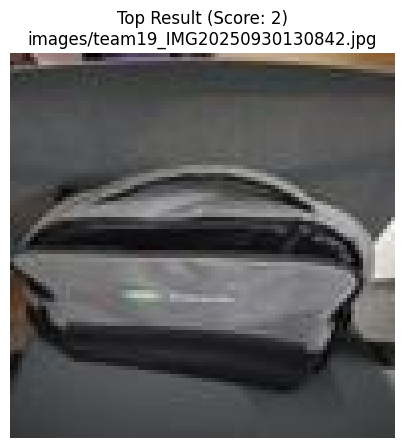

In [ ]:
import random

def extract_keywords(text):
    """
    Parses text with spaCy and extracts key search terms (nouns, adjectives).
    Uses the base word (lemma) for better matching (e.g., "bottles" -> "bottle").
    """
    doc = nlp(text.lower())
    keywords = set()
    for token in doc:
        # We want nouns, proper nouns, and adjectives
        if token.pos_ in ("NOUN", "PROPN", "ADJ"):
            keywords.add(token.lemma_) # 'lemma_' gives the base word

    # If no keywords found (e.g., "a used shampoo"), just split the string
    if not keywords and text:
         keywords = set(text.lower().split())

    return keywords

def retrieve_images(query_text, index, top_k=5):
    """
    1. Extracts keywords from query_text using spaCy
    2. Scores each image in the index based on keyword matches
    3. Returns the top_k matching image paths
    """
    # 1. Extract keywords from the user's query
    query_keywords = extract_keywords(query_text)
    if not query_keywords:
        print("No keywords extracted from query.")
        return []

    print(f"Searching for keywords: {query_keywords}")

    # 2. Score each image in our index
    scores = []
    for item in index:
        # Our "database" of tags predicted by your ViT
        item_tags = set(item['tags'])

        # Score is simply the number of matching keywords
        match_score = len(query_keywords.intersection(item_tags))

        if match_score > 0:
            scores.append({
                "path": item['image_path'],
                "score": match_score,
                "matched_tags": list(query_keywords.intersection(item_tags))
            })

    # 3. Sort by score (highest first)
    scores.sort(key=lambda x: x['score'], reverse=True)

    return scores[:top_k]

# --- 🚀 LIVE DEMO ---
# Try different queries here!
# query = "blue plastic bottle"
query = "a new leather backpack"
# query = "used shampoo"

retrieved_results = retrieve_images(query, search_index, top_k=5)

if retrieved_results:
    print(f"\n--- Top 5 results for '{query}' ---")
    for result in retrieved_results:
        print(f"Score: {result['score']} | Matched: {result['matched_tags']} | Path: {result['path']}")

    # --- Optional: Display the top image ---
    top_image_path = retrieved_results[0]['path']
    try:
        img = Image.open(top_image_path)
        plt.figure(figsize=(5,5))
        plt.imshow(img)
        plt.title(f"Top Result (Score: {retrieved_results[0]['score']})\n{top_image_path}")
        plt.axis('off')
        plt.show()
    except Exception as e:
        print(f"Could not display image at {top_image_path}: {e}")
else:
    print(f"No results found for '{query}'")

In [ ]:
!zip -r final_model_1.zip deit-small-finetuned/

  adding: deit-small-finetuned/ (stored 0%)
  adding: deit-small-finetuned/final_model_1/ (stored 0%)
  adding: deit-small-finetuned/final_model_1/model.safetensors (deflated 7%)
  adding: deit-small-finetuned/final_model_1/training_args.bin (deflated 53%)
